In [1]:
from __future__ import absolute_import, division,print_function,unicode_literals

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import functools
import time
from PIL import Image
import IPython.display as display

E:\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
# 设置绘图窗口参数， 用于图片显示
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [3]:
# 图片路径
content_path = 'test1.jpg'
style_path = 'cubist.jpg'

In [6]:
# 读取一张图片，并做预处理
def load_img(path_to_img):
    max_dim = 512
    # 读取二进制文件
    img = tf.io.read_file(path_to_img)
    # 做JPEG解码，这时候得到宽x高x色深矩阵，数字0-255
    img = tf.image.decode_jpeg(img)
    # 类型从int转换到32位浮点，数值范围0-1
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 减掉最后色深一维，获取到的相当于图片尺寸（整数），转为浮点
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    # 获取图片长端
    long = max(shape)
    # 以长端为比例缩放，让图片成为512x???
    scale = max_dim/long
    new_shape = tf.cast(shape*scale, tf.int32)
    # 实际缩放图片
    img = tf.image.resize(img, new_shape)
    # 再扩展一维，成为图片数字中的一张图片（1，长，宽，色深）
    img = img[tf.newaxis, :]
    return img

In [7]:
# 读取图片
content_img = load_img(content_path)
style_img = load_img(style_path)

In [10]:
# 定义显示图片
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

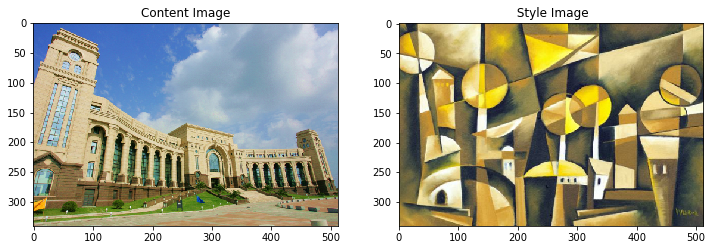

In [12]:
# 查看图片
content_img = load_img(content_path)
style_img = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_img, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_img, ' Style Image')

In [13]:
# 加载vgg19预训练模型
x = tf.keras.applications.vgg19.preprocess_input(content_img * 255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [14]:
# 得到前五预测
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(
    prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('palace', 0.31965798),
 ('church', 0.3016379),
 ('monastery', 0.117898),
 ('castle', 0.07434826),
 ('bell_cote', 0.045382388)]

In [15]:
# 查看vgg层
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [16]:
# 定义最能代表内容的特征的网路曾
content_layers = ['block5_conv2']
# 定义最能代表风格的网络层
style_layers = [
    'block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1',
    'block5_conv1'
]
# 神经网络层的数量
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [17]:
# 定义工具函数， 得到特定中间层输出结果模型
def vgg_layers(layers_means):
    '''
    Creates a vgg model that returns a list of intermediate output values.
    '''
    # 定义ImageNet数据训练的vgg19网络
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    # 已经训练过，所以锁定参数， 设置不训练
    vgg.trainable = False
    # 获取所需层的输出结果
    outputs = [vgg.get_layer(name).output for name in layers_means]
    # 返回结果模型
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [18]:
# 定义函数计算风格矩阵，由抽取出来额5个网络层的输出计算得来的
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

In [22]:
# 定义keras模型
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        # vgg模型，包含上面的风格抽取层和内容抽取层
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        # 锁定参数
        self.vgg.trainable = False

    #定义返回风格
    def call(self, input):
        # 输入的图片是0-1范围浮点，转换到0-255
        input = input * 255.0
        # 对输入的图片数据做预处理
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(
            input)
        #获取风格层和内容层输出
        outputs = self.vgg(preprocessed_input)
        # 拆分风格输出和内容输出
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        #计算风格矩阵
        style_outputs = [
            gram_matrix(style_output) for style_output in style_outputs
        ]

        # 转换为字典
        content_dict = {
            content_name: value
            for content_name, value in zip(self.content_layers,
                                           content_outputs)
        }
        # 转换为字典
        style_dict = {
            style_name: value
            for style_name, value in zip(self.style_layers, style_outputs)
        }
        # 返回内容和风格结果
        return {'content': content_dict, 'style': style_dict}

In [24]:
# 建立模型抽取器
extractor = StyleContentModel(style_layers, content_layers)

# 设定风格特征目标，
style_targets = extractor(style_img)['style']
# 这顶内容特征目标
content_targets = extractor(content_img)['content']

In [25]:
# 内容图片转换为张量
image = tf.Variable(content_img)


# 截取0-1的浮点数，超范围部分被截取
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


# 优化器
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
# 预定义风格和内容在最终结果中的权重值，用于在损失函数中计算总损失值
style_weight = 1e-2
content_weight = 1e4


# 损失函数
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    # 风格损失值，就是计算方差
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
        for name in style_outputs.keys()
    ])
    # 权重值平均到每层，计算总体风格损失值
    style_loss *= style_weight / num_style_layers

    # 内容损失值，也是计算方差
    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers
    # 总损失值
    loss = style_loss + content_loss
    return loss

In [26]:
# 一次训练
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        # 抽取风格层、内容层输出
        outputs = extractor(image)
        # 计算损失值
        loss = style_content_loss(outputs)

    # 梯度下降
    grad = tape.gradient(loss, image)
    # 应用计算后的新参数，注意这个新值不是应用到网络
    # 作为训练完成的vgg网络，其参数前面已经设定不可更改
    # 这个参数实际将应用于原图
    # 以求取，新图片经过网络后，损失值最小
    opt.apply_gradients([(grad, image)])
    # 更新图片，用新图片进行下次训练迭代
    image.assign(clip_0_1(image))


start = time.time()
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    print("")
    # 每100次迭代显示一次图片
    # imshow(image.read_value())
    # plt.title("Train step: {}".format(step))
    # plt.show()

end = time.time()
print("Total time: {:.1f}".format(end - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..................................................................................................

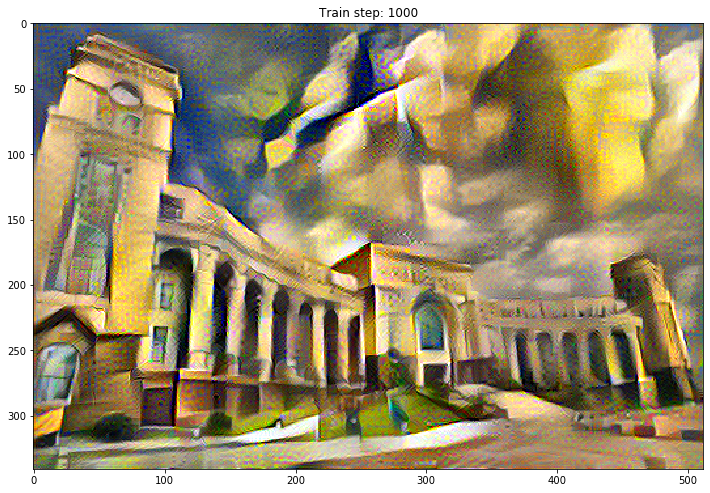

In [32]:
imshow(image.read_value())
plt.title("Train step: {}".format(step))
plt.show()

In [33]:
# 计算x方向及y方向相邻像素差值，如果有高频花纹，这个值肯定会高，
# 因为相邻点相同差值接近0，区别越大，差值当然越大
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var


# 计算总体变分损失
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)


# 总体变分损失值在损失值中所占权重
total_variation_weight = 1e8

In [34]:
# 一次训练
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        # 抽取风格层、内容层输出
        outputs = extractor(image)
        # 计算损失值
        loss = style_content_loss(outputs)
        loss += total_variation_weight * total_variation_loss(image)

    # 梯度下降
    grad = tape.gradient(loss, image)
    # 应用计算后的新参数，注意这个新值不是应用到网络
    # 作为训练完成的vgg网络，其参数前面已经设定不可更改
    # 这个参数实际将应用于原图
    # 以求取，新图片经过网络后，损失值最小
    opt.apply_gradients([(grad, image)])
    # 更新图片，用新图片进行下次训练迭代
    image.assign(clip_0_1(image))

In [40]:
# 内容图片作为逐步迭代生成的新图片，一开始当然是原图，这里是转换为张量
image = tf.Variable(content_img)

start = time.time()

# 迭代10次，每次100步训练
epochs = 10
steps = 100

step = 0
for n in range(epochs):
    for m in range(steps):
        step += 1
        train_step(image)
        print(".", end='')
    print("")
end = time.time()
print("Total time: {:.1f}".format(end - start))

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................................

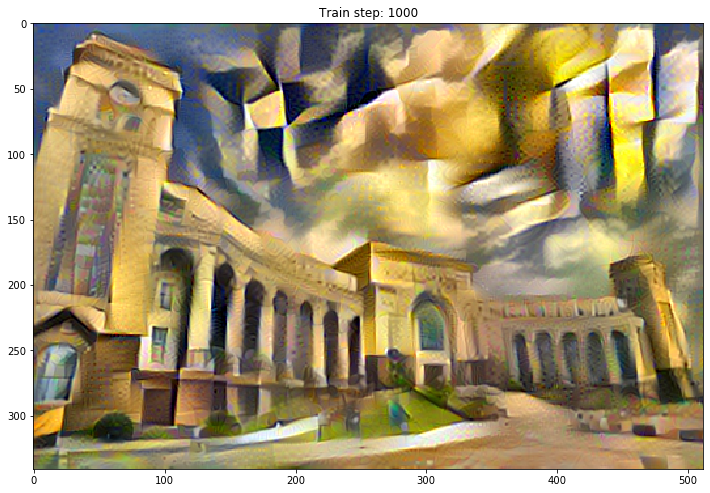

In [42]:
imshow(image.read_value())
plt.title("Train step: {}".format(step))
plt.show()

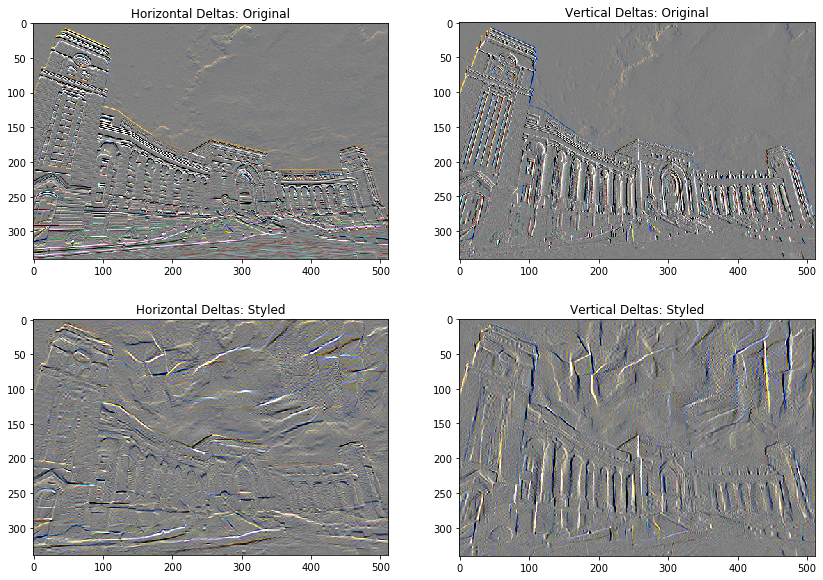

In [67]:
# 可视化损失变化，显示了高频分量是如何增加的。
x_deltas, y_deltas = high_pass_x_y(content_img)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

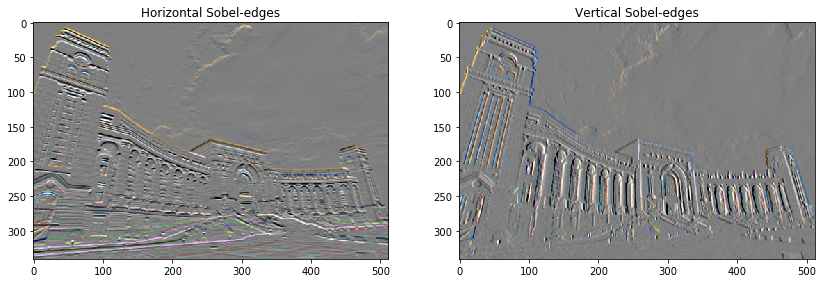

In [68]:
# 高频分量基本上是一个边缘检测器。您可以从sobel边缘检测器获得类似的输出，
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_img)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")